# Anti-hater filter for social networks 

This notebook documents the development of an **anti-hater filter** for automatic moderation of user comments (multi-label) across 6 categories: `toxic`, `severe_toxic`, `obscene`, `threat`, `insult`, `identity_hate`.
The goal is to **reduce manual moderation load** while keeping discussion quality high, with a particular focus on **maximizing true positives (TP) and minimizing false negatives (FN)** for rare/critical classes.

## Dataset & Problem

* **Dataset:** \~160k comments with binary multi-label annotations.
* **Strong imbalance:** some classes are very rare (e.g., `threat` \~0.3%, `identity_hate` < 1%).
* **Task:** multi-label classification → the model outputs 6 probabilities ∈ \[0, 1], one per category.

## Pipeline (overview)

1. **Quick EDA:** shape, dtypes, missing values, class distributions, text length, and label co-occurrence.
2. **Text normalization:** lowercase, `<URL>`, `<USER>`, `<NUM>`, emoji to text, de-elongation, leet→plain, `unidecode`, spacing.
3. **Stratified split:** **train/val/test = 80/10/10**, stratified by the number of active labels per row (`num_labels`).
4. **Tokenization:** `TextVectorization` (word-level) with `max_tokens=20k`, `seq_len=128`; save sequences and vocabulary; estimate **OOV rate**.
5. **Imbalance handling:** **Weighted BCE** with per-class positive weights `w_pos = neg/pos` (normalized to mean = 1).
6. **Model:** **2× BiLSTM** with `return_sequences=True` + **mask-aware pooling** (Global Max + Global Avg) → `Dropout → Dense(128, ReLU) → Dense(6, sigmoid)`.

   * `Embedding(200, mask_zero=True)` + `SpatialDropout1D(0.2)`
   * Mask-aware pooling respects the padding mask and avoids bias from padded timesteps.
7. **Training:** `AdamW(lr=1e-3, weight_decay=1e-4, clipnorm=1.0)`,
   metrics: multi-label **PR-AUC**, **macro F1**, **BinaryAccuracy**.
   Callbacks: `ModelCheckpoint / EarlyStopping / ReduceLROnPlateau` **monitoring `val_pr_auc`**.
8. **Threshold tuning (validation):** per-class thresholds from **Precision–Recall curve** points maximizing **Fβ** (β>1 to favor recall on rare classes) or via a **precision floor**.
   Save optimal thresholds and apply them to the **test** set (no re-tuning → no leakage).
9. **Final evaluation:** per-class report (precision/recall/F1), micro/macro-F1, **PR-AUC**, **TP/FP/FN** counts, and saving of thresholds/training history/model.

## What’s in the Notebook

* Cells for **EDA**, normalization, tokenization, and saving artifacts (`X_*_tokenized.npy`, `y_*.npy`, `vocabulary.txt`).
* Implementation of **Weighted BCE** and **mask-aware pooling layers**.
* Utilities for **threshold tuning** and **evaluation** (`evaluate_final_model`) with printed metrics and per-label PR-AUC.
* **Checkpoints:** best model (`best_model.keras`) and **final model** (`final_model.keras`), plus `training_history.pkl` and `best_thresholds.npy`.

## Why This Setup

* Bi-directional RNNs + light pooling capture **context** and **salient tokens** with reasonable cost (CPU-friendly).
* **Weighted BCE** compensates class imbalance without distorting multi-label examples.
* **Per-class threshold tuning** from the **PR curve** optimizes operational trade-offs (recall vs precision) based on moderation goals.

> **Practical note:** if your goal is **recall-first** (maximize TP, minimize FN) for critical categories (`threat`, `identity_hate`), use **β > 1** during threshold tuning or the **precision-floor** strategy.


In [1]:
!pip install pandas numpy matplotlib seaborn regex emoji unidecode tqdm tensorflow scikit-learn

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji
import string
from unidecode import unidecode
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
import time
import json

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, SpatialDropout1D, Bidirectional, LSTM, 
    GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate, 
    Dropout, Dense
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import AdamW

from tensorflow.keras import metrics as km
from keras.metrics import F1Score

import pickle
import sklearn.metrics as skmetrics
from sklearn.metrics import (
    classification_report,
    precision_recall_curve,
    auc,
    f1_score,
)
from typing import Optional, Dict, Any

2025-08-08 12:25:43.652461: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-08 12:25:43.713664: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-08 12:25:46.003078: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# 1. EDA

Explorative analysis to understand the dataset.

- Loads Filter_Toxic_Comments_dataset.csv into a DataFrame.

- Prints a preview (head()), dataset size, column names, dtypes, and missing values (sanity checks).

- Defines the 6 toxicity labels and prints per-class counts and percentages.

- Adds num_labels = number of active labels per comment and shows its distribution.

- Computes comment_length (characters) and prints descriptive statistics.

- Plots a histogram of comment_length with the median marked.

- Prints one example comment for each label (first match found).

Results:

 - Shape: 159,571 rows × 8 columns; no missing values.

 - Class imbalance: positives are rare

 - toxic 9.58%, severe_toxic 1.00%, obscene 5.29%, threat 0.30%, insult 4.94%, identity_hate 0.88%.

 - Multi-label mix: ~89.83% of comments have 0 labels; a minority have 1–6 labels.

 - Lengths: median ≈ 205 chars (mean ≈ 394), long right tail up to 5,000; the histogram confirms this skew.

 - Examples: printed snippets illustrate typical texts; a single comment may appear under multiple labels (multi-label ground truth).

First 5 rows of the dataset:


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0



Dataset information:
Number of rows: 159571
Number of columns: 8

Columns in the dataset:
['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'sum_injurious']

Data types:


comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
sum_injurious     int64
dtype: object


Missing values per column:


comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
sum_injurious    0
dtype: int64


Distribution of toxicity categories:
toxic: 15294 comments (9.58%)
severe_toxic: 1595 comments (1.00%)
obscene: 8449 comments (5.29%)
threat: 478 comments (0.30%)
insult: 7877 comments (4.94%)
identity_hate: 1405 comments (0.88%)

Distribution of number of labels per comment:


num_labels
0    143346
1      6360
2      3480
3      4209
4      1760
5       385
6        31
Name: count, dtype: int64

Percentage of non-toxic comments: 89.83%

Statistics on comment length:


count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_length, dtype: float64

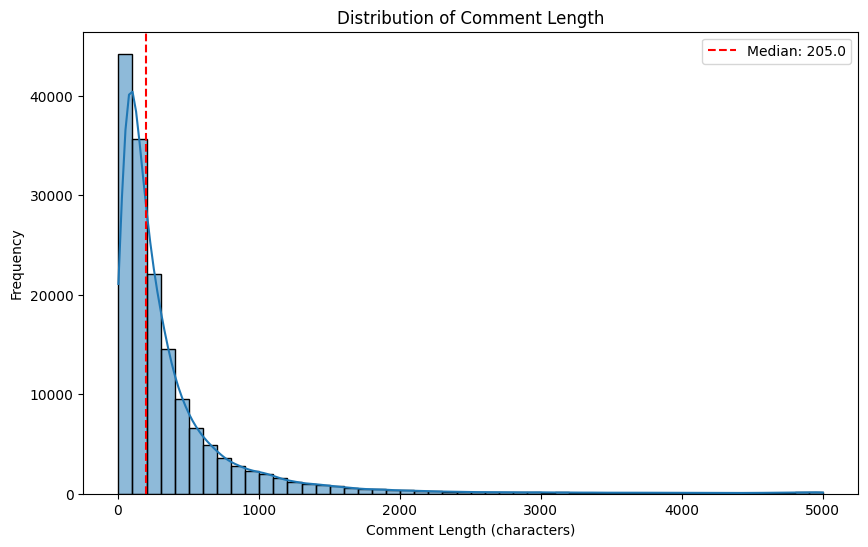


Examples of comments for each category:

--- Example of 'toxic' comment ---
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

--- Example of 'severe_toxic' comment ---
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

--- Example of 'obscene' comment ---
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

--- Example of 'threat' comment ---
Hi! I am back again!
Last warning!
Stop undoing my edits or die!

--- Example of 'insult' comment ---
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

--- Example of 'identity_hate' comment ---
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gyp...


In [3]:
df = pd.read_csv('Filter_Toxic_Comments_dataset.csv')

print("First 5 rows of the dataset:")
display(df.head())

print("\nDataset information:")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

print("\nColumns in the dataset:")
print(df.columns.tolist())

print("\nData types:")
display(df.dtypes)

print("\nMissing values per column:")
display(df.isnull().sum())

toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# Class distribution (how many comments per category)
print("\nDistribution of toxicity categories:")
for label in toxic_labels:
    count = df[label].sum()
    percentage = (count / len(df)) * 100
    print(f"{label}: {count} comments ({percentage:.2f}%)")

# Count of comments with multiple labels
df['num_labels'] = df[toxic_labels].sum(axis=1)
print("\nDistribution of number of labels per comment:")
display(df['num_labels'].value_counts().sort_index())
print(f"Percentage of non-toxic comments: {(df['num_labels'] == 0).mean() * 100:.2f}%")

# Comment length
df['comment_length'] = df['comment_text'].apply(len)
print("\nStatistics on comment length:")
display(df['comment_length'].describe())

# Visualization of comment length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['comment_length'], bins=50, kde=True)
plt.title('Distribution of Comment Length')
plt.xlabel('Comment Length (characters)')
plt.ylabel('Frequency')
plt.axvline(df['comment_length'].median(), color='r', linestyle='--', label=f'Median: {df["comment_length"].median()}')
plt.legend()
plt.show()

# Examples of comments for each category
print("\nExamples of comments for each category:")
for label in toxic_labels:
    print(f"\n--- Example of '{label}' comment ---")
    example = df[df[label] == 1]['comment_text'].iloc[0]
    print(example[:200] + "..." if len(example) > 200 else example)

##### Analyze co-occurring labels

- Builds a string key for each row with all active labels (e.g., toxic-insult).

- Counts the top-10 most frequent label combinations (excluding empty).

- Computes a correlation matrix across the 6 labels and plots a heatmap.


Analyzing comments with multiple toxicity labels:

Most common label combinations:


/tmp/ipykernel_118905/3695296090.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label_combos = df[toxic_labels].apply(lambda x: '-'.join(toxic_labels[i] for i in range(len(toxic_labels)) if x[i] == 1), axis=1)


toxic                                              5666
toxic-obscene-insult                               3800
toxic-obscene                                      1758
toxic-insult                                       1215
toxic-severe_toxic-obscene-insult                   989
toxic-obscene-insult-identity_hate                  618
obscene                                             317
insult                                              301
toxic-severe_toxic-obscene-insult-identity_hate     265
obscene-insult                                      181
Name: count, dtype: int64

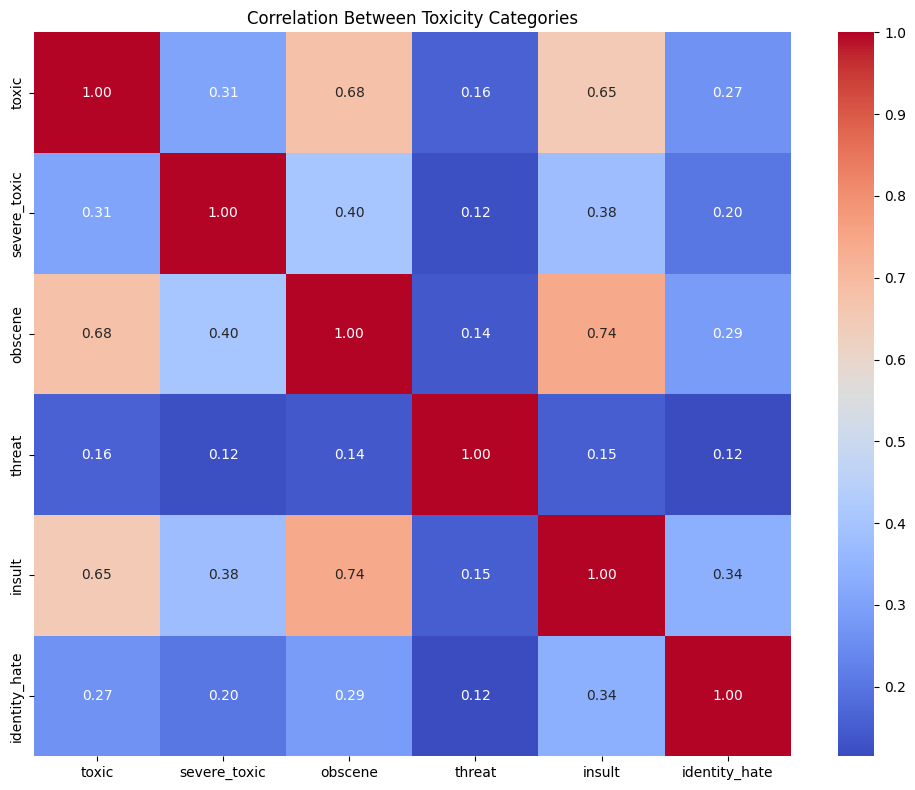

In [4]:
# Analyze comments with multiple labels
print("\nAnalyzing comments with multiple toxicity labels:")

# Count occurrences of label combinations
print("\nMost common label combinations:")
label_combos = df[toxic_labels].apply(lambda x: '-'.join(toxic_labels[i] for i in range(len(toxic_labels)) if x[i] == 1), axis=1)
top_combos = label_combos[label_combos != ''].value_counts().head(10)
display(top_combos)

plt.figure(figsize=(10, 8))
corr_matrix = df[toxic_labels].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Between Toxicity Categories")
plt.tight_layout()
plt.show()


# 2. Data Preprocessing

#### Normalization

Defines normalize_text(text), a reusable function that standardizes raw comments before tokenization. It:

- lowercases the text;

- replaces URLs with <URL> and @mentions with <USER>;

- converts emojis to text (e.g., 🙂 → :slightly_smiling_face:);

- collapses character elongations ("soooo" → "soo");

- temporarily marks dates/times with placeholders to avoid corrupting them during leet mapping;

- maps common leet-speak digits/symbols to letters (4→a, 1→i, @→a, …);

- normalizes unicode to ASCII (unidecode);

- replaces standalone numbers with <NUM>;

- trims/condenses whitespace.

Non-string safety: if the input isn’t a string (e.g., NaN), it returns an empty string "".

In [5]:
def normalize_text(text):
    """
    Normalize text with various techniques:
    - Convert to lowercase
    - Replace URLs with <URL> placeholder
    - Replace user mentions with <USER> placeholder
    - Handle emojis (convert to text)
    - Fix character repetitions
    - Convert leet speak ("1d10t" → "idiot")
    - Normalize unicode characters to ASCII
    - Standardize spacing
    """
    # Check if text is a string (some entries might be NaN)
    if not isinstance(text, str):
        return ""
    
    
    text = text.lower()

    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(url_pattern, '<URL>', text)
    
    mention_pattern = r'@\w+'
    text = re.sub(mention_pattern, '<USER>', text)
    
    text = emoji.demojize(text)
    
    # Fix character repetitions (more than 2 of the same character)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    
	# Identify and preserve dates and times before leet speak conversion
    # First, temporarily mark date/time patterns
    date_patterns = [
        # Time patterns (HH:MM)
        r'\b\d{1,2}:\d{2}\b',
        # Date patterns (MM/DD/YYYY, DD/MM/YYYY, YYYY/MM/DD)
        r'\b\d{1,2}/\d{1,2}/\d{2,4}\b',
        r'\b\d{2,4}-\d{1,2}-\d{1,2}\b',
        # Month name patterns
        r'\b\d{1,2}\s+(?:january|february|march|april|may|june|july|august|september|october|november|december)\b',
        r'\b(?:january|february|march|april|may|june|july|august|september|october|november|december)\s+\d{1,2}\b',
    ]
    
    # Temporary placeholders for dates/times
    date_replacements = {}
    for i, pattern in enumerate(date_patterns):
        matches = re.finditer(pattern, text, re.IGNORECASE)
        for j, match in enumerate(matches):
            placeholder = f"<DATE_TIME_{i}_{j}>"
            date_replacements[placeholder] = match.group()
            text = text.replace(match.group(), placeholder)
            
    # Convert common leet speak patterns
    leet_patterns = {
        '0': 'o', '1': 'i', '3': 'e', '4': 'a', '5': 's', 
        '6': 'g', '7': 't', '8': 'b', '@': 'a', '$': 's'
    }
    for digit, letter in leet_patterns.items():
        text = text.replace(digit, letter)
    
    # Normalize unicode characters (optional - can be commented out if needed)
    text = unidecode(text)
    
    # Replace numbers with <NUM> placeholder
    text = re.sub(r'\b\d+\b', '<NUM>', text)
    
    # Standardize spacing (remove extra spaces)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

#### Applying Normalization

- Applies normalize_text to every comment with a progress bar (tqdm) and stores results in df['normalized_text'].

- Prints 5 original vs normalized snippets for spot-checking.

- Counts how many empty strings remain after normalization (sanity check).

- Computes and displays length stats before/after normalization.

- Plots overlaid histograms of text lengths (original vs. normalized).

Normalizing text data...


100%|██████████| 159571/159571 [01:04<00:00, 2456.74it/s]



Examples of original vs. normalized text:

Original: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't ...
Normalized: explanation why the edits made under my username hardcore metallica fan were reverted? they weren't ...

Original: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11...
Normalized: d'aww! he matches this background colour i'm seemingly stuck with. thanks. (talk) <DATE_TIME_o_o>, <...

Original: Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant ...
Normalized: hey man, i'm really not trying to edit war. it's just that this guy is constantly removing relevant ...

Original: "
More
I can't make any real suggestions on improvement - I wondered if the section statistics shoul...
Normalized: " more i can't make any real suggestions on improvement - i wondered if the section statistics shoul...

Original: You, sir, are my hero.

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_length, dtype: float64


Statistics on text length after normalization:


count    159571.000000
mean        388.335800
std         582.028464
min           5.000000
25%          94.000000
50%         202.000000
75%         430.000000
max        5708.000000
Name: normalized_length, dtype: float64

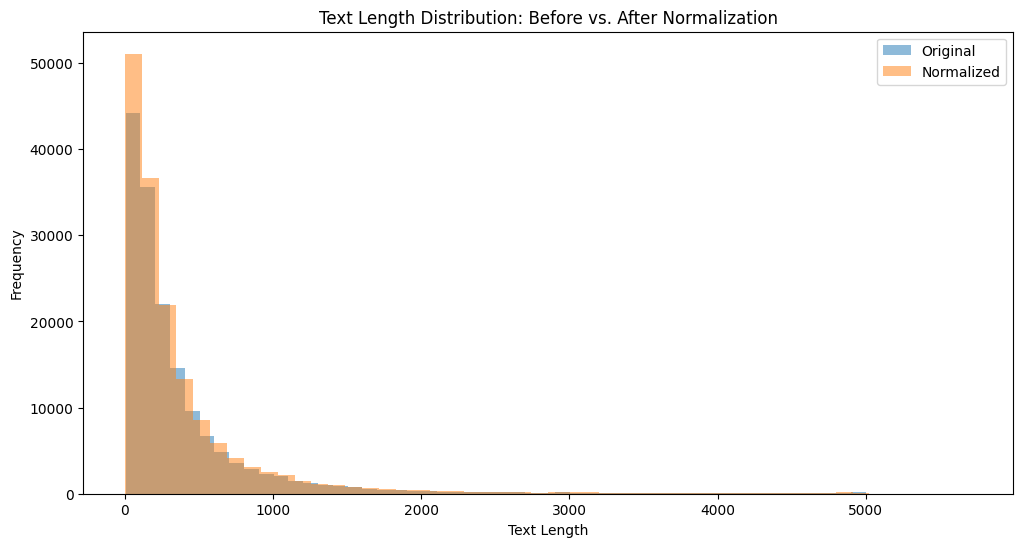

In [6]:
# Apply normalization to the dataset with progress bar
print("Normalizing text data...")
df['normalized_text'] = [normalize_text(text) for text in tqdm(df['comment_text'])]

# Display examples of original vs. normalized text
print("\nExamples of original vs. normalized text:")
for i in range(5):
    print(f"\nOriginal: {df['comment_text'].iloc[i][:100]}...")
    print(f"Normalized: {df['normalized_text'].iloc[i][:100]}...")

# Check if there are any remaining empty texts after normalization
empty_texts = df['normalized_text'].apply(lambda x: len(x) == 0).sum()
print(f"\nNumber of empty texts after normalization: {empty_texts}")

# Show statistics on text length before and after normalization
df['normalized_length'] = df['normalized_text'].apply(len)
print("\nStatistics on text length before normalization:")
display(df['comment_length'].describe())
print("\nStatistics on text length after normalization:")
display(df['normalized_length'].describe())

# Visualize the difference in text length
plt.figure(figsize=(12, 6))
plt.hist(df['comment_length'], bins=50, alpha=0.5, label='Original')
plt.hist(df['normalized_length'], bins=50, alpha=0.5, label='Normalized')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Distribution: Before vs. After Normalization')
plt.legend()
plt.show()

##### Tokenization

#### OOV Rate Helper

Defines calculate_oov_rate(texts, vectorizer), which computes the out-of-vocabulary (OOV) rate: the share of tokens in texts that are not present in the TextVectorization vocabulary (vectorizer.get_vocabulary()).

Iterates over each text, splits on whitespace, counts total tokens and how many are missing from the vocab.

Returns a single float in [0, 1] (e.g., 0.07 = 7% OOV).

In [7]:
def calculate_oov_rate(texts, vectorizer):
    """Calculate the percentage of words not in vocabulary."""
    oov_count = 0
    total_count = 0
    
    for text in texts:
        words = text.split()
        total_count += len(words)
        
        for word in words:
            if word not in vectorizer.get_vocabulary():
                oov_count += 1
    
    return oov_count / total_count if total_count > 0 else 0

#### Batch Tokenization Helper

Defines process_in_batches(texts, vectorizer, batch_size=2048, max_sequence_length=1000) to convert raw texts into integer sequences in batches using a TextVectorization layer.

- Pre-allocates a NumPy array of shape (num_samples, max_sequence_length) with int32 dtype.

- Iterates over texts (expects a pandas Series) in chunks of batch_size.

- Applies vectorizer(batch_texts) on each chunk and writes the result into the pre-allocated array.

- Shows a tqdm progress bar.

- Returns the full 2D array of token IDs.

In [8]:
def process_in_batches(texts, vectorizer, batch_size=2048, max_sequence_length=1000):
    """Process texts in batches to improve performance."""
    num_samples = len(texts)
    sequences = np.zeros((num_samples, max_sequence_length), dtype=np.int32)

    for i in tqdm(range(0, num_samples, batch_size), desc="Processing batches"):
        end_idx = min(i + batch_size, num_samples)
        batch_texts = texts.iloc[i:end_idx].values
        sequences[i:end_idx] = vectorizer(batch_texts).numpy()
    
    return sequences

#### Tokenization, stratified split, and export

- Prepare sample for vocabulary: takes up to 50k normalized texts to adapt the TextVectorization (builds a 20k-word vocab; seq length 128).

- Stratified split: creates train / val / test = 80/10/10 by stratifying on num_labels (number of active labels) to preserve multi-label density.

- Adapt & inspect tokenizer: adapts on the vocab sample, prints vocab size and a few tokenization examples (original vs token list).

- Batch vectorization: converts X_train, X_val, X_test to integer sequences via process_in_batches(...) with a progress bar.

- OOV check: computes the out-of-vocabulary rate on a small validation sample.

- Persistence: saves tokenized arrays (X_*_tokenized.npy), labels (y_*.npy), and the vocabulary.txt.

- Timing: prints the time spent adapting and processing to give you a rough performance profile.

In [9]:
print("# 3. Tokenization")
start_time = time.time()

print(f"\nUtilize the full dataset ({len(df)} rows)...")
working_df = df

# Taking a sample for vocabulary creation
print("\nPreparing data for tokenization...")
sample_size_for_vocab = min(50000, len(working_df))
vocab_sample = working_df['normalized_text'].sample(sample_size_for_vocab, random_state=42).values

label_count = df[toxic_labels].sum(axis=1).clip(0, 6)
X_train, X_temp, y_train, y_temp = train_test_split(
        df['normalized_text'],
        df[toxic_labels],
        test_size=0.2,
        random_state=42,
        stratify=label_count)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=label_count[X_temp.index]
)

# Tokenizer parameters
max_tokens = 20000  
max_sequence_length = 128  


print("\nInitialization and adaptation of the tokenizer...")
word_vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_sequence_length,
    standardize=None 
)

print("Adapting the vocabulary...")
word_vectorizer.adapt(vocab_sample)
vocab_time = time.time()
print(f"Time to adapt the vocabulary: {vocab_time - start_time:.2f} seconds")

# Vocabulary information
word_vocab = word_vectorizer.get_vocabulary()
word_vocab_size = len(word_vocab)
print(f"Vocabulary size: {word_vocab_size} tokens")

# Tokenization examples
print("\nTokenization examples:")
for i in range(3):
    original_text = X_train.iloc[i][:50] + "..." if len(X_train.iloc[i]) > 50 else X_train.iloc[i]
    tokenized_text = word_vectorizer([X_train.iloc[i]]).numpy()[0]
    non_zero_tokens = tokenized_text[tokenized_text > 0]
    tokens = [word_vocab[idx] for idx in non_zero_tokens]
    print(f"\nOriginal: {original_text}")
    print(f"Token: {tokens[:10]}{'...' if len(tokens) > 10 else ''}")


print("\nConverting texts to sequences (batch processing)...")
print("Processing training set...")
X_train_sequences = process_in_batches(X_train, word_vectorizer, max_sequence_length=max_sequence_length)
print("Processing validation set...")
X_val_sequences = process_in_batches(X_val, word_vectorizer, max_sequence_length=max_sequence_length)
print("Processing test set...")
X_test_sequences = process_in_batches(X_test, word_vectorizer, max_sequence_length=max_sequence_length)

process_time = time.time()
print(f"Time to process all sequences: {process_time - vocab_time:.2f} seconds")

print(f"Training data shape: {X_train_sequences.shape}")
print(f"Validation data shape: {X_val_sequences.shape}")


# Calculate OOV rate on a small sample (use a smaller sample for speed)
print("\nCalculating OOV rate...")
sample_size = min(500, len(X_val))
oov_rate = calculate_oov_rate(X_val.sample(sample_size).values, word_vectorizer)
print(f"OOV rate in validation data: {oov_rate:.2%}")

# Saving tokenized data
print("\nSaving tokenized data...")
np.save('X_train_tokenized.npy', X_train_sequences)
np.save('X_val_tokenized.npy', X_val_sequences)
np.save('X_test_tokenized.npy', X_test_sequences)
np.save('y_train.npy', y_train.values)
np.save('y_val.npy', y_val.values)
np.save('y_test.npy', y_test.values)

with open('vocabulary.txt', 'w') as f:
    for word in word_vocab:
        f.write(f"{word}\n")

end_time = time.time()
total_time = end_time - start_time
print(f"\nTokenization complete! Total time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

# 3. Tokenization

Utilize the full dataset (159571 rows)...

Preparing data for tokenization...

Initialization and adaptation of the tokenizer...
Adapting the vocabulary...
Time to adapt the vocabulary: 1.08 seconds
Vocabulary size: 20000 tokens

Tokenization examples:

Original: comment signed by jackthomas
Token: [np.str_('comment'), np.str_('signed'), np.str_('by'), '[UNK]']

Original: the article is written in neutral language. it was...
Token: [np.str_('the'), np.str_('article'), np.str_('is'), np.str_('written'), np.str_('in'), np.str_('neutral'), np.str_('language.'), np.str_('it'), np.str_('was'), np.str_('sourced')]...

Original: " have sheperd instead. "
Token: [np.str_('"'), np.str_('have'), '[UNK]', np.str_('instead.'), np.str_('"')]

Converting texts to sequences (batch processing)...
Processing training set...


Processing batches: 100%|██████████| 63/63 [00:01<00:00, 56.10it/s]


Processing validation set...


Processing batches: 100%|██████████| 8/8 [00:00<00:00, 58.87it/s]


Processing test set...


Processing batches: 100%|██████████| 8/8 [00:00<00:00, 36.56it/s]


Time to process all sequences: 1.53 seconds
Training data shape: (127656, 128)
Validation data shape: (15957, 128)

Calculating OOV rate...
OOV rate in validation data: 9.24%

Saving tokenized data...

Tokenization complete! Total time: 844.46 seconds (14.07 minutes)


#### Class imbalance handling with per-class weights

- Loads y_train.npy and prints per-class label distribution (positives, ratio, negatives).

- Computes positive weights per class as negatives / positives and sets the **negative weight = 1.0`.

- Normalizes all weights so that the average weight = 1 (keeps the loss scale stable).

- Prints a sanity check (average before/after normalization) and the final weights per class.

- Saves them to class_weights.json (keys are stringified indices 0..5, each with { "0": w_neg, "1": w_pos }).

In [10]:
# 4. Class Imbalance Handling with Class Weights
print("# 4. Class Imbalance Handling with Class Weights")

# Load the training data
y_train = np.load('y_train.npy')

print("\nLabel distribution in training set:")
for i, label in enumerate(toxic_labels):
    pos_count = np.sum(y_train[:, i])
    neg_count = y_train.shape[0] - pos_count
    pos_ratio = pos_count / y_train.shape[0]
    print(f"{label}: {pos_count} positive ({pos_ratio:.2%}), {neg_count} negative")

# Calculate weights for each class
print("\nCalculating class weights...")
class_weights = {}
weight_sums = []

for i, label in enumerate(toxic_labels):
    pos_count = np.sum(y_train[:, i])
    neg_count = y_train.shape[0] - pos_count
    
    # Weight calculation: negatives / positives
    # To avoid division by zero
    if pos_count > 0:
        weight_pos = neg_count / pos_count
    else:
        weight_pos = 1.0
    
    weight_neg = 1.0  # Weight for negative class is always 1
    
    # Dictionary of weights for this class
    class_weights[i] = {0: weight_neg, 1: weight_pos}
    
    # For normalization
    avg_weight = (neg_count * weight_neg + pos_count * weight_pos) / y_train.shape[0]
    weight_sums.append(avg_weight)

# Normalize weights to have mean = 1
avg_weight_total = np.mean(weight_sums)
print(f"Average weight before normalization: {avg_weight_total:.4f}")

normalized_class_weights = {}
for i in class_weights:
    normalized_class_weights[i] = {
        0: class_weights[i][0] / avg_weight_total,
        1: class_weights[i][1] / avg_weight_total
    }

# Verify normalization
normalized_weight_sums = []
for i, label in enumerate(toxic_labels):
    pos_count = np.sum(y_train[:, i])
    neg_count = y_train.shape[0] - pos_count
    
    avg_norm_weight = (neg_count * normalized_class_weights[i][0] + 
                       pos_count * normalized_class_weights[i][1]) / y_train.shape[0]
    normalized_weight_sums.append(avg_norm_weight)

print(f"Average weight after normalization: {np.mean(normalized_weight_sums):.4f}")

# Display calculated weights
print("\nNormalized class weights:")
for i, label in enumerate(toxic_labels):
    print(f"{label}: Negative={normalized_class_weights[i][0]:.4f}, Positive={normalized_class_weights[i][1]:.4f}")

# Save class weights for training
import json
with open('class_weights.json', 'w') as f:
    # Convert keys to strings for JSON serialization
    serializable_weights = {str(k): {str(sk): sv for sk, sv in v.items()} 
                          for k, v in normalized_class_weights.items()}
    json.dump(serializable_weights, f)

print("\nClass weights saved to 'class_weights.json'")

# 4. Class Imbalance Handling with Class Weights

Label distribution in training set:
toxic: 12224 positive (9.58%), 115432 negative
severe_toxic: 1265 positive (0.99%), 126391 negative
obscene: 6761 positive (5.30%), 120895 negative
threat: 374 positive (0.29%), 127282 negative
insult: 6323 positive (4.95%), 121333 negative
identity_hate: 1132 positive (0.89%), 126524 negative

Calculating class weights...
Average weight before normalization: 1.9267
Average weight after normalization: 1.0000

Normalized class weights:
toxic: Negative=0.5190, Positive=4.9012
severe_toxic: Negative=0.5190, Positive=51.8580
obscene: Negative=0.5190, Positive=9.2808
threat: Negative=0.5190, Positive=176.6386
insult: Negative=0.5190, Positive=9.9597
identity_hate: Negative=0.5190, Positive=58.0119

Class weights saved to 'class_weights.json'


# 3. Model

#### Class weights vector + weighted BCE loss

- Loads y_train.npy and counts positives/negatives per class.

- Builds a positive weight vector w_pos = neg/pos, then normalizes it so the mean is 1.0 (keeps the loss scale stable).

- Prints a weights_dict mapping each label → its positive weight (rounded for readability).

- Creates class_weights as a TensorFlow constant (shape (6,)).

- Defines weighted_bce(y_true, y_pred): standard binary cross-entropy per class, multiplied by w_pos only for positive targets; then averages across the 6 labels.

In [11]:

y_train = np.load('y_train.npy')
pos = y_train.sum(axis=0)                
neg = y_train.shape[0] - pos             


w_pos = neg / np.maximum(pos, 1)
w_pos = w_pos / w_pos.mean()
weights_dict = {label: float(weight) for label, weight in zip(toxic_labels, w_pos.round(2))}
print(weights_dict)

class_weights = tf.constant(w_pos, dtype=tf.float32)


def weighted_bce(y_true, y_pred):
    
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    # if y=1 apply w_pos, if y=0 leave 1
    weights = 1. + (class_weights - 1.) * y_true
    return tf.reduce_mean(bce * weights, axis=-1)


{'toxic': 0.09, 'severe_toxic': 1.0, 'obscene': 0.18, 'threat': 3.41, 'insult': 0.19, 'identity_hate': 1.12}


#### Mask-aware global pooling layers

Defines two custom Keras layers that respect the time mask coming from Embedding(mask_zero=True):

 - MaskedGlobalMaxPool1D: replaces masked timesteps with a large negative value (-1e9) before reduce_max, so padding is ignored in the max.

 - MaskedGlobalAveragePool1D: computes a masked mean: sums only unmasked timesteps and divides by the (masked) count.

In [21]:
from keras.saving import register_keras_serializable
@register_keras_serializable(package="custom")
class MaskedGlobalMaxPool1D(tf.keras.layers.Layer):
    """Global max pooling that respects the input mask."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
    def call(self, x, mask=None):
        if mask is not None:
            mask = tf.cast(mask, x.dtype)[:, :, None]  # (B,T,1)
            neg_inf = tf.constant(-1e9, x.dtype)
            x = tf.where(tf.equal(mask, 1.), x, neg_inf)
        return tf.reduce_max(x, axis=1)
    
@register_keras_serializable(package="custom")
class MaskedGlobalAveragePool1D(tf.keras.layers.Layer):
    """Global average pooling that ignores padded (masked) timesteps."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
    def call(self, x, mask=None):
        if mask is not None:
            mask = tf.cast(mask, x.dtype)[:, :, None]
            sum_  = tf.reduce_sum(x * mask, axis=1)
            cnt   = tf.reduce_sum(mask, axis=1)
            return sum_ / tf.maximum(cnt, 1e-8)
        return tf.reduce_mean(x, axis=1)

#### Model architecture (2×BiLSTM + mask-aware pooling)

Defines build_model(...) that returns a compiled Keras model ready for training:

 - Embedding(200, mask_zero=True) + SpatialDropout1D(0.2).

 - Two BiLSTM layers (128 then 64 units) with return_sequences=True (keeps the time axis for pooling) and recurrent_dropout=0.2.

 - Mask-aware pooling: MaskedGlobalMaxPool1D + MaskedGlobalAveragePool1D, then Concatenate.

 - Classifier head: Dropout(0.4) → Dense(128, ReLU) → Dense(6, sigmoid) (multi-label outputs).

 - Optimizer: AdamW(lr=1e-3, weight_decay=1e-4, clipnorm=1.0).

 - Loss: weighted_bce (class-weighted BCE).

 - Metrics: binary accuracy (0.5 threshold), PR-AUC (multi-label), macro F1 (0.5 threshold).

In [13]:
# Model architecture
def build_model(sequence_length=128, vocab_size=20001, embedding_dim=200, n_classes=6, lr =1e-3):
    # 1. Input layer
    input_layer = Input(shape=(sequence_length,))
    
    # 2. Embedding layer with mask_zero=True
    x = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=sequence_length,
        mask_zero=True
    )(input_layer)

    # 3. SpatialDropout1D to reduce overfitting in the embedding
    x = SpatialDropout1D(0.2)(x)

    # 4. BiLSTM layers (2 layers)
    x = Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2))(x)
    x = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.2))(x)

    # 5. Pooling: Concatenate Global Max and Global Average pooling
    max_pool = MaskedGlobalMaxPool1D()(x)
    avg_pool = MaskedGlobalAveragePool1D()(x)
    pooled = Concatenate()([max_pool, avg_pool])

    # 6. Final layers
    x = Dropout(0.4)(pooled)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(n_classes, activation='sigmoid')(x)
    
	# Optimizer
    optimizer = AdamW(
    learning_rate=lr,
    weight_decay=1e-4,
	clipnorm=1.0
    )
    
    
    metric_list = [
    km.BinaryAccuracy(name="bin_acc", threshold=0.5),
    km.AUC(name="pr_auc", curve="PR",
           multi_label=True, num_labels=n_classes),
    km.F1Score(name="f1_macro", average="macro", threshold=0.5),
	]
    
    # Create and compile model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=optimizer,
        loss=weighted_bce,
        metrics=metric_list
    )
        
    return model


#### Load tokenized arrays & metadata

- Loads pre-saved tokenized splits: X_train/val/test_tokenized.npy and y_train/val/test.npy.

- Prints detected sequence length and the shapes of all arrays (sanity check).

- Loads the saved vocabulary (vocabulary.txt) and reports its size (for the Embedding layer).

- Opens class_weights.json (serialized per-class weights) for later use during training.

In [14]:
# Load tokenized data from saved files
print("Loading tokenized data from saved files...")
X_train = np.load('X_train_tokenized.npy')
X_val = np.load('X_val_tokenized.npy')
X_test = np.load('X_test_tokenized.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')
y_test = np.load('y_test.npy')

# Get the sequence length from the loaded data
max_sequence_length = X_train.shape[1]
print(f"Detected sequence length: {max_sequence_length}")

print(f"Loaded data shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")
print(f"y_test: {y_test.shape}")

# Load vocabulary from saved file
with open('vocabulary.txt', 'r') as f:
    saved_vocabulary = [line.strip() for line in f.readlines()]

# Get vocabulary size
vocab_size = len(saved_vocabulary)
print(f"Loaded vocabulary size: {vocab_size}")

# Get class weights from saved file and convert to the format needed for training
with open('class_weights.json', 'r') as f:
    serialized_weights = json.load(f)


Loading tokenized data from saved files...
Detected sequence length: 128
Loaded data shapes:
X_train: (127656, 128)
X_val: (15957, 128)
X_test: (15958, 128)
y_train: (127656, 6)
y_val: (15957, 6)
y_test: (15958, 6)
Loaded vocabulary size: 20000


#### Build model & print summary

- Defines training hyperparameters: batch_size=256, max_epochs=12, lr=1e-3.

- Calls build_model(...) with the detected sequence_length, the loaded vocab_size, embedding size 200, and n_classes=6.

- Prints the Keras model summary (layer stack, output shapes, parameter counts).

In [15]:
# Params
batch_size = 256  
max_epochs = 12
lr = 1e-3

print(f"Building the model with params: batch_size={batch_size}, max_epochs={max_epochs}, lr={lr}")

model = build_model(
	sequence_length=max_sequence_length,
    vocab_size=vocab_size,
    embedding_dim=200,
    n_classes=len(toxic_labels),
    lr=lr  
)
print("\nModel summary:")
print(model.summary())


Building the model with params: batch_size=256, max_epochs=12, lr=0.001



Model summary:


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 128, 200)  │  4,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 128, 200)  │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 128)       │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128, 256)  │    336,896 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128, 128)  │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_global_max_… │ (None, 128)       │          0 │ bidirectional_1[… │
│ (MaskedGlobalMaxPo… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_global_aver… │ (None, 128)       │          0 │ bidirectional_1[… │
│ (MaskedGlobalAvera… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ masked_global_ma… │
│ (Concatenate)       │                   │            │ masked_global_av… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 6)         │        774 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,534,918 (17.30 MB)

 Trainable params: 4,534,918 (17.30 MB)

 Non-trainable params: 0 (0.00 B)

None


#### Model training

Defines callbacks aligned to your objective (PR-AUC):

 - ModelCheckpoint('best_model.keras', monitor='val_pr_auc', mode='max') saves the best validation model.

 - EarlyStopping(monitor='val_pr_auc', patience=4, restore_best_weights=True) stops when PR-AUC stops improving.

 - ReduceLROnPlateau(monitor='val_pr_auc', factor=0.5, patience=2, min_lr=1e-5, cooldown=1, min_delta=1e-4) halves LR when PR-AUC plateaus.

 - Starts training with the chosen batch size / epochs / LR and reports dataset sizes.

 - Trains the model on (X_train, y_train) with validation on (X_val, y_val).

 - Measures and prints total training time.

Saves:

 - the final (best-restored) model to final_model.keras

 - the training history dict to training_history.pkl.

In [16]:
print("# 6. Model Training")

# Update callbacks with patience 4 for early stopping
callbacks = [
    ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_pr_auc',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_pr_auc',
        patience=4,  
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_pr_auc',
        factor=0.5,
        patience=2,
		min_lr=1e-5,
		cooldown=1,
		min_delta=1e-4,
        verbose=1
    )
]


print(f"\nStarting training with batch size={batch_size}, max_epochs={max_epochs}")
print(f"Using AdamW optimizer with learning rate {lr}")
print(f"Training on {len(X_train)} examples, validating on {len(X_val)} examples")

start_time = time.time()

# Train the model with class weights
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=max_epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

end_time = time.time()
training_time = end_time - start_time
print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

# Save the trained model and history
model.save('final_model.keras')
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("\nModel and training history saved successfully.")


# 6. Model Training

Starting training with batch size=256, max_epochs=12
Using AdamW optimizer with learning rate 0.001
Training on 127656 examples, validating on 15957 examples
Epoch 1/12


2025-08-08 12:41:14.901911: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - bin_acc: 0.9552 - f1_macro: 0.0392 - loss: 0.1000 - pr_auc: 0.0718
Epoch 1: val_pr_auc improved from None to 0.45870, saving model to best_model.keras
499/499 ━━━━━━━━━━━━━━━━━━━━ 917s 2s/step - bin_acc: 0.9645 - f1_macro: 0.0773 - loss: 0.0556 - pr_auc: 0.1475 - val_bin_acc: 0.9704 - val_f1_macro: 0.1619 - val_loss: 0.0310 - val_pr_auc: 0.4587 - learning_rate: 0.0010
Epoch 2/12
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - bin_acc: 0.9730 - f1_macro: 0.2223 - loss: 0.0287 - pr_auc: 0.4621
Epoch 2: val_pr_auc improved from 0.45870 to 0.49419, saving model to best_model.keras
499/499 ━━━━━━━━━━━━━━━━━━━━ 913s 2s/step - bin_acc: 0.9733 - f1_macro: 0.2467 - loss: 0.0285 - pr_auc: 0.4799 - val_bin_acc: 0.9755 - val_f1_macro: 0.3229 - val_loss: 0.0284 - val_pr_auc: 0.4942 - learning_rate: 0.0010
Epoch 3/12
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - bin_acc: 0.9747 - f1_macro: 0.3049 - loss: 0.0258 - pr_auc: 0.5113
Epoch 3: val_pr_auc improved from 0.4941

# 4. Evaluation

#### Threshold tuning & final evaluation utilities

optimal_thresholds_from_pr(y_true, y_prob, beta=1.0)
 - Finds, for each class, the threshold among the Precision–Recall curve points that maximizes F_β (β>1 favors recall). Safe fallback to 0.5 if the curve is degenerate.

evaluate_final_model(model_path, X_path, y_path, thresholds=None, ...)

 1. Loads the saved Keras model and NumPy arrays.

 2. Computes probabilities on the given split.

 3. If thresholds is None, calls optimal_thresholds_from_pr(...) to tune them on this split.

 4. Binarizes predictions using the thresholds.

 - Produces:

   - classification_report (per-class precision/recall/F1, plus micro/macro/weighted).

   - Simple TP/FP/FN counts per class.

   - PR-AUC per class.

   - Returns a dict with thresholds, classification_report, confusion, pr_auc.

In [17]:
def optimal_thresholds_from_pr(y_true: np.ndarray,
                               y_prob: np.ndarray,
                               beta: float | np.ndarray = 1.0) -> np.ndarray:
    """
    Pick, for each class, the threshold among the PR-curve points that maximizes F_beta.

    Parameters
    ----------
    y_true : (N, C) array of ground-truth binary labels.
    y_prob : (N, C) array of predicted probabilities.
    beta   : scalar or (C,) array controlling the F_beta trade-off (beta>1 favors recall).

    Returns
    -------
    (C,) array with the selected threshold for each class.
    """
    n_classes = y_true.shape[1]
    if np.isscalar(beta):
        beta = np.full(n_classes, float(beta), dtype=np.float32)
    beta = np.asarray(beta, dtype=np.float32)

    best = np.zeros(n_classes, dtype=np.float32)
    for i in range(n_classes):
        prec, rec, thr = precision_recall_curve(y_true[:, i], y_prob[:, i])
        # sklearn returns len(thr) = len(prec) - 1
        prec_, rec_ = prec[:-1], rec[:-1]
        b2 = beta[i] * beta[i]
        denom = b2 * prec_ + rec_
        fbeta = (1.0 + b2) * (prec_ * rec_) / np.maximum(denom, 1e-12)

        if np.all(~np.isfinite(fbeta)):
            best[i] = 0.5  # safe fallback
        else:
            j = int(np.nanargmax(fbeta))
            best[i] = float(thr[j])
    return best



def evaluate_final_model(model_path: str,
                         X_path: str,
                         y_path: str,
                         thresholds: Optional[np.ndarray] = None,
                         batch_size: int = 1024,
                         verbose: bool = True
                        ) -> Dict[str, Any]:
    """
    Load the model and data, compute detailed metrics.
    
    Parameters
    ----------
    model_path : path del file .keras
    X_path     : path numpy (N, seq_len) int32
    y_path     : path numpy (N, 6)       int8
    thresholds : array(6,) optional, if None, compute optimal thresholds
    batch_size : inference batch
    verbose    : print results to console

    Returns
    -------
    dict with thresholds, sklearn report and PR-AUC for each class
    """
    
    model = tf.keras.models.load_model(model_path, compile=False)
    X = np.load(X_path)
    y = np.load(y_path)
    
    
	# Probability and prediction
    y_prob = model.predict(X, batch_size=batch_size, verbose=0)
    
    if thresholds is None:
        thresholds = optimal_thresholds_from_pr(y, y_prob)
    
    y_pred = (y_prob >= thresholds).astype(int)
    
    # Basic metrics
    report = classification_report(
        y, y_pred, target_names=toxic_labels, zero_division=0, output_dict=True
    )
    
    # Simple confusion matrix
    conf = {}
    for i, lbl in enumerate(toxic_labels):
        tp = int(((y[:, i] == 1) & (y_pred[:, i] == 1)).sum())
        fp = int(((y[:, i] == 0) & (y_pred[:, i] == 1)).sum())
        fn = int(((y[:, i] == 1) & (y_pred[:, i] == 0)).sum())
        conf[lbl] = {"TP": tp, "FP": fp, "FN": fn}
    
    # PR-AUC for each class
    pr_auc = {}
    for i, lbl in enumerate(toxic_labels):
        prec, rec, _ = precision_recall_curve(y[:, i], y_prob[:, i])
        pr_auc[lbl] = auc(rec, prec)
    
    if verbose:
        print("=== Classification report ===")
        print(classification_report(
            y, y_pred, target_names=toxic_labels, zero_division=0
        ))
        print("\n=== Confusion (TP FP FN) ===")
        for lbl in toxic_labels:
            tpfpfn = conf[lbl]
            print(f"{lbl:13}  TP={tpfpfn['TP']:5}  "
                  f"FP={tpfpfn['FP']:5}  FN={tpfpfn['FN']:5}")
        print("\n=== PR-AUC ===")
        for lbl in toxic_labels:
            print(f"{lbl:13}: {pr_auc[lbl]:.3f}")
        print("\nThresholds:", thresholds.round(3))
    
    return {
        "thresholds": thresholds,
        "classification_report": report,
        "confusion": conf,
        "pr_auc": pr_auc,
    }


#### Re-saving the model considering the custom function

In [23]:
custom_objects = {
    "MaskedGlobalMaxPool1D": MaskedGlobalMaxPool1D,
    "MaskedGlobalAveragePool1D": MaskedGlobalAveragePool1D,
}
model = tf.keras.models.load_model("best_model.keras",
                                   custom_objects=custom_objects,
                                   compile=False)

model.save("best_model_registered.keras")  # re-save with registered classes


#### Threshold tuning and final test

- Validation predictions: loads best_model.keras, runs predict on X_val_tokenized.npy, and saves val_probs.npy.

- Threshold search (PR-curve): computes per-class thresholds via optimal_thresholds_from_pr with
- betas = [1.0, 1.0, 1.0, 1.5, 1.0, 1.5] (favoring recall for threat and identity_hate to reduce FN). Saves best_thresholds.npy.

- Final evaluation on test: calls evaluate_final_model on final_model.keras using the fixed thresholds. Prints a full report (per-class precision/recall/F1, micro/macro averages), TP/FP/FN per class, PR-AUC, and the thresholds used.

In [26]:
# Threshold tuning and final test

# Prediction on validation set
model = tf.keras.models.load_model("best_model_registered.keras", compile=False) 
X_val = np.load("X_val_tokenized.npy")
y_val = np.load("y_val.npy")
val_probs = model.predict(X_val, batch_size=256, verbose=0)
np.save("val_probs.npy", val_probs)

# Threshold tuning
betas = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0], dtype=np.float32)  
best_th = optimal_thresholds_from_pr(y_val, val_probs, beta=betas)
np.save("best_thresholds.npy", best_th)

# Final test
test_results = evaluate_final_model(
    model_path="best_model_registered.keras",
    X_path="X_test_tokenized.npy",
    y_path="y_test.npy",
    thresholds=best_th,
    batch_size=256,
    verbose=True
)


=== Classification report ===
               precision    recall  f1-score   support

        toxic       0.75      0.70      0.72      1531
 severe_toxic       0.42      0.57      0.49       164
      obscene       0.81      0.70      0.75       838
       threat       0.35      0.27      0.31        55
       insult       0.59      0.73      0.65       785
identity_hate       0.28      0.32      0.30       139

    micro avg       0.67      0.68      0.68      3512
    macro avg       0.53      0.55      0.54      3512
 weighted avg       0.68      0.68      0.68      3512
  samples avg       0.06      0.06      0.06      3512


=== Confusion (TP FP FN) ===
toxic          TP= 1079  FP=  367  FN=  452
severe_toxic   TP=   94  FP=  128  FN=   70
obscene        TP=  588  FP=  142  FN=  250
threat         TP=   15  FP=   28  FN=   40
insult         TP=  573  FP=  405  FN=  212
identity_hate  TP=   45  FP=  113  FN=   94

=== PR-AUC ===
toxic        : 0.795
severe_toxic : 0.471
obscene   

#### Precision-floor threshold selection
What it does
- Selects, for each class, the decision threshold that yields the highest recall subject to a minimum precision (the “precision floor”). If no threshold on the PR curve meets that floor, it falls back to the threshold that maximizes F1 (computed safely to avoid numerical warnings).

Why use it
- When false negatives are costly (recall-first policy) but you still want to cap false positives, this method enforces a minimum precision while squeezing as much recall as possible.

In [30]:
def thresholds_with_precision_floor(y_true, y_prob, min_precision):
    """
    Pick threshold with max recall s.t. precision >= floor.
    If none, fall back to best F1 computed safely.
    """
    n_classes = y_true.shape[1]
    out = np.zeros(n_classes, dtype=np.float32)
    for i in range(n_classes):
        prec, rec, thr = precision_recall_curve(y_true[:, i], y_prob[:, i])
        prec, rec = prec[:-1], rec[:-1]          # align with thr
        thr = thr.astype(np.float32)

        mask = prec >= float(min_precision[i])
        if np.any(mask):
            j_local = int(np.argmax(rec[mask]))  # max recall under floor
            out[i] = float(thr[np.flatnonzero(mask)[j_local]])
        else:
            # Safe F1 (no invalid divide)
            denom = prec + rec
            f1 = np.zeros_like(denom, dtype=np.float32)
            np.divide(2 * prec * rec, denom, out=f1, where=denom > 0)
            j = int(np.argmax(f1)) if f1.size else 0
            out[i] = float(thr[j])
    return out


In [31]:
# Set per-class precision floor
floors = np.array([0.75, 0.45, 0.80, 0.35, 0.60, 0.40], dtype=np.float32)
best_th_pf = thresholds_with_precision_floor(y_val, val_probs, floors)
np.save("best_thresholds_precision_floor.npy", best_th_pf)


test_results_pf = evaluate_final_model(
    model_path="best_model_registered.keras",
    X_path="X_test_tokenized.npy",
    y_path="y_test.npy",
    thresholds=best_th_pf,
    batch_size=256,
    verbose=True
)


=== Classification report ===
               precision    recall  f1-score   support

        toxic       0.74      0.71      0.73      1531
 severe_toxic       0.45      0.42      0.44       164
      obscene       0.77      0.74      0.75       838
       threat       0.24      0.42      0.30        55
       insult       0.59      0.73      0.65       785
identity_hate       0.28      0.32      0.30       139

    micro avg       0.66      0.69      0.67      3512
    macro avg       0.51      0.56      0.53      3512
 weighted avg       0.67      0.69      0.68      3512
  samples avg       0.06      0.06      0.06      3512


=== Confusion (TP FP FN) ===
toxic          TP= 1084  FP=  375  FN=  447
severe_toxic   TP=   69  FP=   84  FN=   95
obscene        TP=  618  FP=  189  FN=  220
threat         TP=   23  FP=   74  FN=   32
insult         TP=  576  FP=  407  FN=  209
identity_hate  TP=   45  FP=  113  FN=   94

=== PR-AUC ===
toxic        : 0.795
severe_toxic : 0.471
obscene   

# Conclusions & Result Interpretation

**Objective:** maximize **TP** and minimize **FN**, while keeping precision reasonable on rare/critical classes.

## Overall

* **Micro F1 = 0.67**, **Macro F1 = 0.53** → strong performance on frequent labels; competitive on rare ones (inherently harder).
* **Per-class PR-AUC** values are **well above prevalence** (`threat 0.201`, `identity_hate 0.218`, etc.), indicating **good ranking**. This means better precision/recall trade-offs are achievable with different thresholds depending on policy.

## Per-class (precision / recall / F1) & operational notes

* **toxic** — `0.74 / 0.71 / 0.73`
  Solid and stable. Good separation; remaining FN (447) are acceptable given current threshold.
* **severe\_toxic** — `0.45 / 0.42 / 0.44`
  Balanced but tight. If you want more TP, slightly lower the threshold or the precision floor for this label.
* **obscene** — `0.77 / 0.74 / 0.75`
  Very good. Strong ranking (PR-AUC 0.828), efficient trade-off already.
* **threat** — `0.24 / 0.42 / 0.30`
  Recall-first priority met (TP=23, FN=32). If we need even fewer FN, drop the precision floor a bit (accepting more FP).
* **insult** — `0.59 / 0.73 / 0.65`
  High recall (TP=576) with many FP (407). Consider a slightly higher precision floor if FP are costly.
* **identity\_hate** — `0.28 / 0.32 / 0.30`
  Big FP reduction achieved (303 → 113), expected recall drop. If we need more TP, reduce the floor (e.g., 0.40→0.30) and retune.

## Final thresholds used

`[toxic=0.054, severe_toxic=0.462, obscene=0.124, threat=0.243, insult=0.063, identity_hate=0.439]`
These align with a **recall-first** strategy for `threat`/`insult` and a more cautious stance on `identity_hate` to curb FP.

## What these numbers tell us

* The model’s **ranking is strong** (high PR-AUC per class), so **good operating points exist**.
* Threshold tuning **rebalanced the error profile** according to policy: fewer FN on critical classes, with FP controlled via precision-floor.